In [83]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit
import numpy as np

data = pd.read_csv('C:/Users/Bitar/Desktop/Training/dataset/student/student-mat.csv',sep=';')
data['school'] = data['school'].str.replace('"', '', regex=False)
split_data = data['school'].str.split(';', expand=True)
# يمكننا تسمية الأعمدة الجديدة إذا أردنا
split_data.columns = [data.columns[i] for i in range(split_data.shape[1])]
# تحويل الأعمدة  إلى نوع العدد الصحيح
split_data['G1'] = pd.to_numeric(split_data['G1'], errors='coerce')
split_data['G3'] = pd.to_numeric(split_data['G3'], errors='coerce')
split_data['freetime'] = pd.to_numeric(split_data['freetime'], errors='coerce')
split_data['failures'] = pd.to_numeric(split_data['failures'], errors='coerce')
print("\n--- Check Missing Values ---")
print(split_data.isnull().sum())

# Add column'pass'
split_data['pass'] = np.where(split_data['G3'] >= 10, 1, 0)
print(split_data.columns)


--- Check Missing Values ---
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64
Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'pass'],
      dtype='object')


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

selected_features = [ 'freetime', 'failures', 'G1']

X = split_data[selected_features]
y = split_data['pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # لإظهار المصفوفة
import matplotlib.pyplot as plt
import numpy as np

conf_matrix = confusion_matrix(y_test, y_pred)
print("مصفوفة الارتباك الخام:")
print(conf_matrix)


مصفوفة الارتباك الخام:
[[26 13]
 [11 69]]


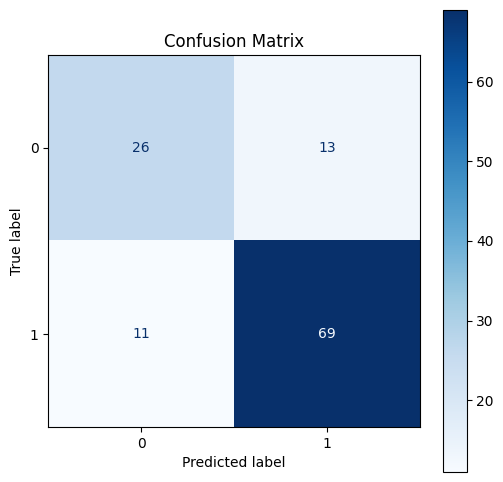

In [86]:
fig, ax = plt.subplots(figsize=(6, 6)) # لضبط حجم الشكل
cmp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
cmp.plot(ax=ax, cmap=plt.cm.Blues) # cmap لتغيير الألوان، يمكنك تجربة 'viridis', 'YlGn'
ax.set_title('Confusion Matrix') # عنوان المخطط
plt.show()

In [87]:
# 3. استخراج المعاملات وأسماء الأعمدة

# LogisticRegression.coef_ تُرجع مصفوفة ثنائية الأبعاد (1, n_features) للتصنيف الثنائي
# لذلك نأخذ الصف الأول [0]
feature_coefficients = model.coef_[0]

# أسماء الأعمدة من بيانات التدريب X_train
feature_names = X_train.columns

# 4. ربط المعاملات بأسماء الأعمدة وإنشاء DataFrame
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': feature_coefficients
})

# 5. تصنيف الأعمدة حسب الأهمية (القيمة المطلقة للمعامل)
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

print("Feature Importance (Coefficients) from Logistic Regression:")
print(coefficients_df)

# يمكنك أيضًا تحديد عدد معين من أهم الأعمدة
print("\nTop 3 Most Important Features:")
print(coefficients_df.head(3))

Feature Importance (Coefficients) from Logistic Regression:
    Feature  Coefficient  Abs_Coefficient
1  failures    -0.682662         0.682662
2        G1     0.633172         0.633172
0  freetime    -0.521130         0.521130

Top 3 Most Important Features:
    Feature  Coefficient  Abs_Coefficient
1  failures    -0.682662         0.682662
2        G1     0.633172         0.633172
0  freetime    -0.521130         0.521130


In [88]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference

sensitive_features = X_test['failures']
print("\n---Evaluating Fairness Using Fairlearn (Example) ---\n")

# 2. حساب الفروقات في مقاييس الإنصاف
# الفروقات هي قيمة موجبة تشير إلى مدى التفاوت بين المجموعات

# الفرق في التكافؤ الديموغرافي (Demographic Parity Difference)
# هل نسبة التنبؤات الإيجابية متساوية بين الجنسين؟
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)
print(f"Demographic Parity Difference (failures): {dp_diff:.2f}")

# الفرق في الفرص المتساوية (Equalized Odds Difference)
# هل معدل True Positive و False Positive متساوي بين الجنسين؟
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)
print(f"Equalized Odds Difference (failures): {eo_diff:.2f}")

# استخدام MetricFrame لعرض المقاييس لكل مجموعة
# لنفترض أن 0 = أنثى، 1 = ذكر
metric_frame = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)
print("\nAccuracy for sensitive group (failures):")
print(metric_frame.by_group)


---Evaluating Fairness Using Fairlearn (Example) ---

Demographic Parity Difference (failures): 0.77
Equalized Odds Difference (failures): 1.00

Accuracy for sensitive group (failures):
failures
0    0.787234
1    0.866667
2    1.000000
3    0.333333
Name: accuracy_score, dtype: float64


In [91]:
import joblib
joblib.dump(model, 'success_model.pkl')

['success_model.pkl']

In [92]:
original_feature_names = X_train.columns.tolist()
joblib.dump(original_feature_names, 'original_feature_names.pkl')

['original_feature_names.pkl']